# Tree Analysis 

In [91]:
from __future__ import division 

%matplotlib inline

import os
import re
import sys
import pandas as pd
import seaborn as sns 

from collections import deque
from operator import itemgetter


# Modify the Notebook path
sys.path.append(os.path.join(os.getcwd(), ".."))

from cloudscope.results import Results
from cloudscope.utils.tree import Tree

In [3]:
FIXTURES  = os.path.join("..", "fixtures")
RESULTS   = os.path.join(FIXTURES, "results")

# Results Files with log traces 
FEDERATED = os.path.join(RESULTS, "single", "federated-consistency-20160923.json")
RAFT      = os.path.join(RESULTS, "single", "large-consensus-group-20160923.json")
EVENTUAL  = os.path.join(RESULTS, "single", "eventually-consistent-large-group-20160923.json")

In [4]:
def load_data(path=EVENTUAL):
    with open(path) as f:
        return Results.load(f) 

# Load the logs into memory
logs = [log['log'] for log in load_data().consistency['logs'].values()]

# Branchiness Exploration

In this section, we will explore a variety of definitions of "branchiness" to see if we can come up with a metric for how critical forks in a log actually are - that is, how far do they deviate from a single linear chain. Example trees are as follows:

- **Chain**: every node has only one child except the last, which has zero. 
- **Prong**: a small chain is forked at the end by two equal length branches. 
- **Trident**: a small chain is forked at the end by two equal length branches and one smaller branch. 
- **Thorns**: a chain where every other child has an additional child.
- **Cactus**: a chain where every other child has a branch with two nodes.
- **BTree**: a tree where every node has two children except the leaf nodes. 
- **Fan**: the worst case scenario, no node has a child except the root.  

Obviously these examples can be generalized further, but they should demonstrate different types of trees that we want to compare from the best case (chain) to the worst case (fan). Each of these trees will have the same exact size. 

In [85]:
# Generator Functions 
def generate_chain(size):
    root = Tree("0")
    tree = root
    for idx in xrange(1, size):
        tree = tree.append(str(idx))
        
    assert root.size() == size
    return root 


def generate_prong(size, min_handle=3):
    # Get the number of nodes in the handle 
    # such that the size is evenly divided by two
    handle = min_handle 
    if (size - handle) % 2 != 0:
        handle += 1 
    
    # Get the prong length 
    plength = (size - handle) // 2 
    
    # Create the handle 
    root  = Tree("0")
    tree = root 
    for idx in xrange(1, handle):
        tree = tree.append(str(idx))
    
    # Create the prongs 
    for _ in xrange(2):
        branch = tree 
        for jdx in xrange(0, plength):
            idx += 1
            branch = branch.append(str(idx))
    
    assert root.size() == size
    return root 


def generate_trident(size, handle=4): 
    
    splen = (size - handle) // 3 
    lplen = (size - handle - splen) // 2
    
    # Create the handle 
    root  = Tree("0")
    tree = root 
    for idx in xrange(1, handle):
        tree = tree.append(str(idx))
    
    # Create the prongs 
    for bdx in xrange(3):
        branch  = tree 
        plength = splen if bdx == 1 else lplen 
        for jdx in xrange(0, plength):
            idx += 1
            branch = branch.append(str(idx))
    
    assert root.size() == size
    return root 


def generate_thorns(size, tlen=1):
    # Also generates cactus by supplying tlen=2 
    root   = Tree("0")
    tree   = root 
    label  = 0
    
    for idx in xrange(0, size-1):
        
        if idx % 3 == 0: 
            branch = tree 
            for _ in xrange(tlen):
                if label >= (size-1):
                    break
                label += 1
                branch = branch.append(str(label))
        else:
            if label >= (size-1):
                break
            label += 1
            tree = tree.append(str(label))
    
    assert root.size() == size
    return root 


def generate_btree(size):
    root = Tree("0")
    idx  = 0
    
    children = deque([root])
    while root.size() < size:
        child = children.popleft()
        for _ in xrange(2):
            idx += 1
            if idx >= (size): break 
            children.append(child.append(str(idx)))
    
    assert root.size() == size
    return root   


def generate_fan(size, handle=0):
    root = Tree("0")
    
    # Create the handle 
    tree = root 
    for idx in xrange(1, handle+1):
        tree = tree.append(str(idx))
    
    for idx in xrange(1, size-handle):
        tree.append(str(idx))
    
    assert root.size() == size
    return root

In [89]:
SIZE  = 15
trees = {
    'chain': generate_chain(SIZE), 
    'prong': generate_prong(SIZE), 
    'trident': generate_trident(SIZE),
    'thorns': generate_thorns(SIZE, 1),
    'cactus': generate_thorns(SIZE, 2), 
    'btree': generate_btree(SIZE),
    'fan': generate_fan(SIZE), 
}

In [90]:
for name, tree in trees.items():
    print name 
    print tree.pprint()
    print

btree
0
├─ 1
   ├─ 3
      ├─ 7
      └─ 8
   └─ 4
      ├─ 9
      └─ 10
└─ 2
   ├─ 5
      ├─ 11
      └─ 12
   └─ 6
      ├─ 13
      └─ 14


chain
0
└─ 1
   └─ 2
      └─ 3
         └─ 4
            └─ 5
               └─ 6
                  └─ 7
                     └─ 8
                        └─ 9
                           └─ 10
                              └─ 11
                                 └─ 12
                                    └─ 13
                                       └─ 14


trident
0
└─ 1
   └─ 2
      └─ 3
         ├─ 4
            └─ 5
               └─ 6
                  └─ 7
         ├─ 8
            └─ 9
               └─ 10
         └─ 11
            └─ 12
               └─ 13
                  └─ 14


fan
0
├─ 1
├─ 2
├─ 3
├─ 4
├─ 5
├─ 6
├─ 7
├─ 8
├─ 9
├─ 10
├─ 11
├─ 12
├─ 13
└─ 14


thorns
0
├─ 1
└─ 2
   └─ 3
      ├─ 4
      └─ 5
         └─ 6
            ├─ 7
            └─ 8
               └─ 9
                  ├─ 10
                  └─ 11
         

In [92]:
def normalize(data):
    """
    Computes the z-index of each point in the list of data
    for visual normalization to the space between 0 and 1. 
    """
    minx = min(data) 
    rngx = float(max(data) - minx)
    return [
        float(x - minx) / rngx 
        for x in data 
    ]


def branchiness(tree):
    """
    Computes branchiness as the average shortest distance to 
    each leaf node normalized by the greatest depth.  
    """
    n = float(tree.size())
    d = [float(leaf.depth()) for leaf in tree.leaves()]
    return (sum(d) / float(len(d))) / n if d else 1.0

In [99]:
df = pd.DataFrame([
    {
        'name': name, 
        'forks': tree.forks(), 
        'height': tree.height(), 
        'branchiness': branchiness(tree), 
    } for name, tree in trees.items()
])

df.forks = normalize(df.forks)
df.height = normalize(df.height)

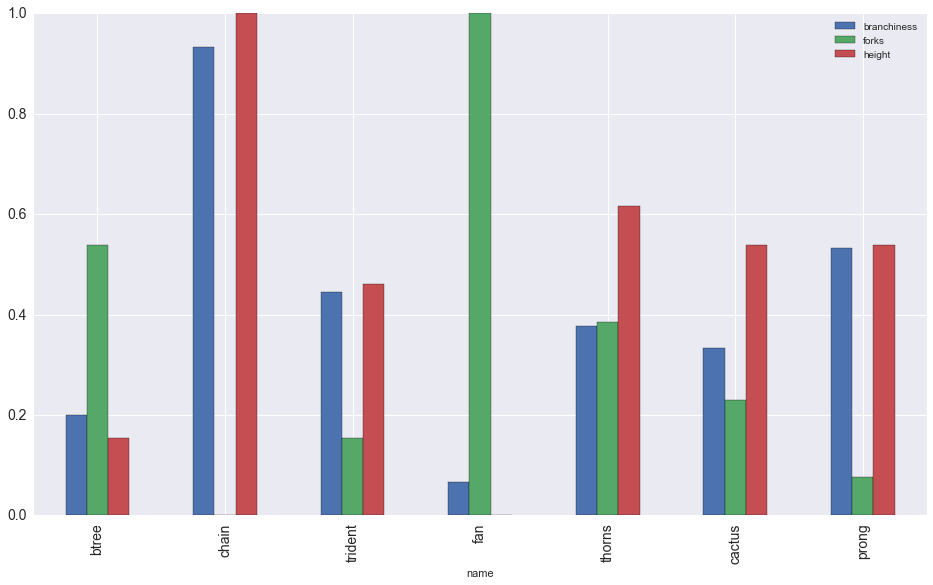

In [109]:
df.plot(kind='bar', x='name', figsize=(16,9), fontsize=14)